# Deeper Look into Fine Channelization
This notebook takes a closer look into the specifics in fine channelization.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. If you do install CuPy to use the GPU, it can be useful to run `export CUDA_VISIBLE_DEVICES=0` before running this notebook to specify a single GPU to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

import numpy as np
import scipy.signal
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt

from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "../../")
import setigen as stg

def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We first set some basic parameters behind the pipeline. `sample_rate` is in samples per second (Hz); `num_taps` and `num_branches` are specific to the polyphase filterbank described below. 

In [4]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

## Creating an Antenna

We will start off with an `Antenna` object, as in the first tutorial. This time, we'll only use a single polarization. Showing noise (and converting from CuPy array if necessary).

In [5]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_signal(f_start=8e6, 
#                      drift_rate=-2*u.Hz/u.s, 
#                      level=0.5,
#                      mode='level')

## Getting real voltage samples and stepping through the pipeline

First, we gather enough samples to be able to eventually do a fine channelization. Here we plot a histogram showing the overall distribution of real voltages.

In [6]:
num_windows = 1024
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

(8396800,)


Quickly stepping through the pipeline:

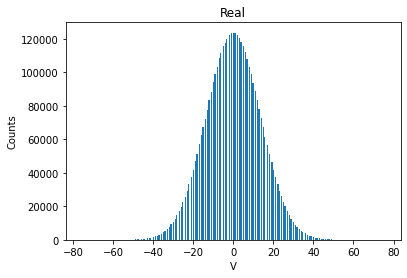

13.592890924549655


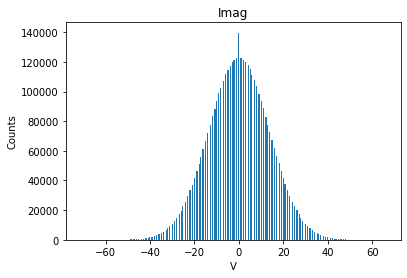

13.578082380959179
Target sigma is 13.589148804608305.


In [7]:
# Digitizing
digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)
v_q = digitizer.quantize(v)

# Channelizing
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)
v_c = filterbank.channelize(v_q)

# Requantizing
num_bits = 8
target_fwhm = 32*2**num_bits/2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)
v_rq = requantizer.quantize(v_c)

plt.hist(get_numpy(v_rq.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.std(get_numpy(v_rq.real.flatten())))

plt.hist(get_numpy(v_rq.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.std(get_numpy(v_rq.imag.flatten())))

sigma = target_fwhm / (2 * np.sqrt(2 * np.log(2)))
print(f'Target sigma is {sigma}.')

## Fine channelization
Here we dive into a simple implementation of fine channelization.

Shape before FFT (num_chans, t_chans, fftlength): (64, 16, 512)

Variance of powers in channel 2 before FFT: 367.4843676891389
Variance of powers in every channel before FFT: 374.0212938892967 

Shape after FFT: (64, 16, 512)
Shape of XX_sub: (64, 16, 128)


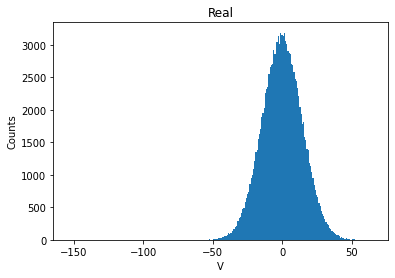

-0.007973702281489444
14.406416754135691


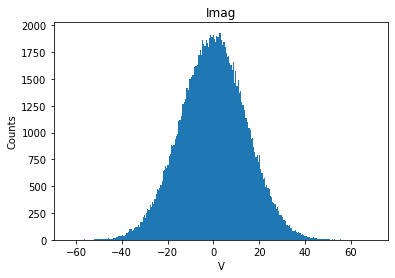

0.008200315637680963
14.316830947580687

XX_psd (mean, std): 370.8073444366455 389.320355502953
XX_psd shape: (64, 16, 512)
XX_psd_sub (mean, std): 412.5166229005504 437.3333899027393
XX_psd_sub shape: (64, 16, 128)
Sub array mean is 1.1124823418135699 times the overall mean

Shape after concatenation: (16, 32768)
Shape after integration: (16, 32768)


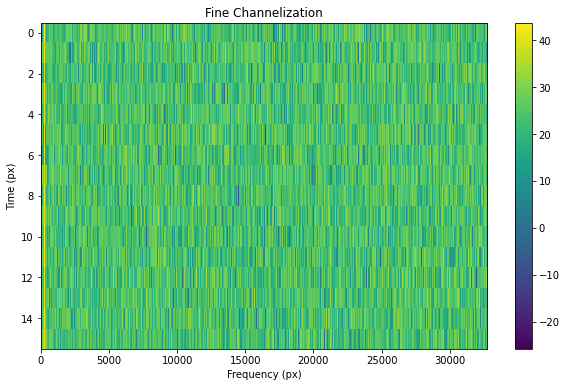

In [8]:
int_factor=1
fftlength=512


# Truncate coarse channels to the first 64.
pfb_voltages = v_rq[:, 0:64]



X_samples = pfb_voltages.T
X_samples = X_samples[:, :(X_samples.shape[1] // fftlength) * fftlength]
X_samples = X_samples.reshape((X_samples.shape[0], X_samples.shape[1] // fftlength, fftlength))
print(f"Shape before FFT (num_chans, t_chans, fftlength): {X_samples.shape}\n")

print('Variance of powers in channel 2 before FFT:', xp.std(xp.abs(X_samples[2, :, :])**2))
print('Variance of powers in every channel before FFT:', xp.std(xp.abs(X_samples[:, :, :])**2),'\n')


XX = xp.fft.fft(X_samples, fftlength, axis=2) / fftlength**0.5
XX = xp.fft.fftshift(XX, axes=2)
XX_psd = xp.abs(XX)**2 #/ fftlength

print(f"Shape after FFT: {XX.shape}")



# XX_sub = XX[:, :, :]
XX_sub = XX[:, :, 3*fftlength//8:5*fftlength//8]
XX_psd_sub = xp.abs(XX_sub)**2
print(f"Shape of XX_sub: {XX_sub.shape}")



plt.hist(get_numpy(XX_sub.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.real.flatten())))

print(np.std(get_numpy(XX_sub.real.flatten())))

plt.hist(get_numpy(XX_sub.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()
print(np.mean(get_numpy(XX_sub.imag.flatten())))
print(np.std(get_numpy(XX_sub.imag.flatten())))
print()


print('XX_psd (mean, std):', xp.mean(XX_psd), xp.std(XX_psd))
print(f"XX_psd shape: {XX_psd.shape}")

print('XX_psd_sub (mean, std):', xp.mean(XX_psd_sub), xp.std(XX_psd_sub))
print(f"XX_psd_sub shape: {XX_psd_sub.shape}")

print(f'Sub array mean is {xp.mean(XX_psd_sub)/xp.mean(XX_psd)} times the overall mean\n')

XX_psd = xp.concatenate(XX_psd, axis=1)
print('Shape after concatenation:', XX_psd.shape)

# Integrate over time, trimming if necessary
XX_psd = XX_psd[:(XX_psd.shape[0] // int_factor) * int_factor]
XX_psd = XX_psd.reshape(XX_psd.shape[0] // int_factor, int_factor, XX_psd.shape[1])
XX_psd = XX_psd.sum(axis=1)

print('Shape after integration:', XX_psd.shape)

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(XX_psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

Integrating over time:

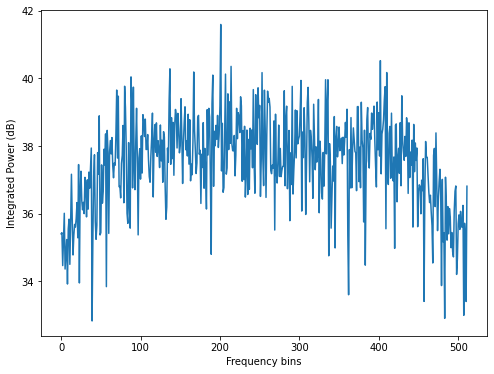

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(db(np.sum(get_numpy(XX_psd), axis=0))[2*fftlength:3*fftlength])
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

Using `scipy` to calculate frequency response of filter used in PFB:

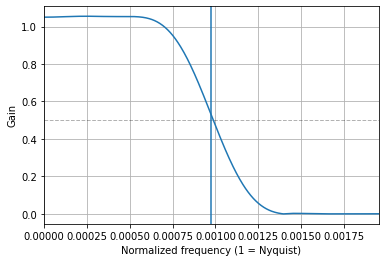

In [10]:
# Desired half-amplitude cutoff
fc = 1.0 / num_branches

window = scipy.signal.get_window('hamming', num_taps * num_branches)
sinc = scipy.signal.firwin(num_taps * num_branches, 
                           cutoff=fc,
                           window='rectangular',
                           scale=True)
window *= sinc

num_points = num_branches*fftlength//2
w, h = freqz(window, worN=num_points)

plt.plot(w/np.pi, np.abs(h))

plt.axhline(0.5, alpha=0.3, color='k', linestyle='--', linewidth=1)
plt.axvline(fc)

plt.grid(True)
plt.xlim(0, 2*fc)
plt.xlabel('Normalized frequency (1 = Nyquist)')
plt.ylabel('Gain')

plt.show()

In [11]:
(w/np.pi)[w/np.pi<fc].shape

(256,)

In [12]:
(w/np.pi<fc).sum()

256

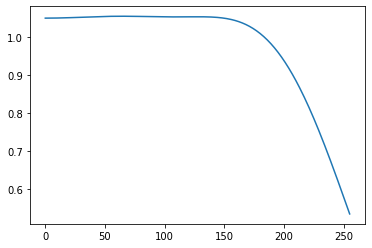

0.9802283503124123

In [13]:
A = np.abs(h)[:(w/np.pi<fc).sum()]
plt.plot(A)
plt.show()

np.mean(A)

In [14]:
np.max(A)/np.mean(A)

1.07626923416567

In [15]:
A[0]

1.0500032688382013

In [16]:
13.6**2*2*1.0773203648327545

398.5223493589325

In [17]:
13.6**2*2*1.1

406.912

In [18]:
13.6**2*2

369.91999999999996

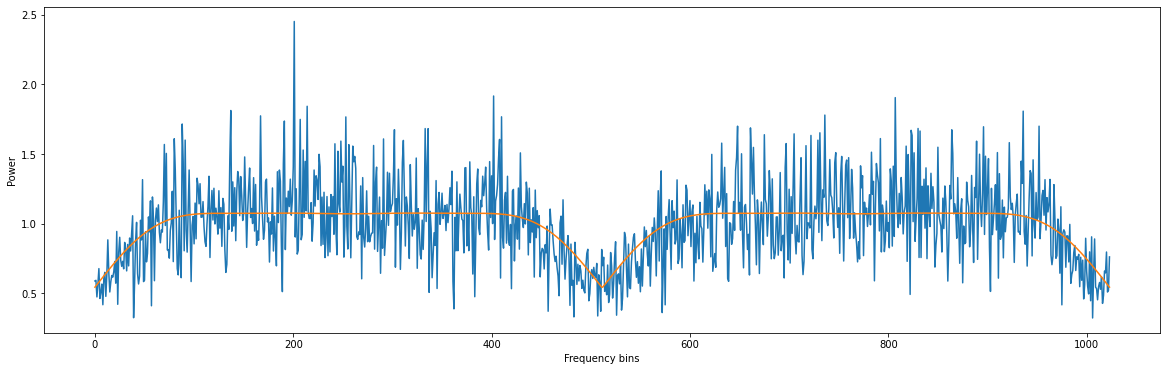

In [19]:
plt.figure(figsize=(20, 6))
m = np.mean((np.sum(get_numpy(XX_psd), axis=0))[2*fftlength:4*fftlength])
plt.plot((np.sum(get_numpy(XX_psd), axis=0))[2*fftlength:4*fftlength]/m)

plt.plot(np.concatenate([A[::-1], A, A[::-1], A])/np.mean(A))

plt.xlabel("Frequency bins")
plt.ylabel("Power")
plt.show()